In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
# Converting mnist image files into a tensot of 4 dimension of (# images , hegiht , width, color)
transform = transforms.ToTensor()

In [114]:
train_data = datasets.MNIST(root='cnn_data', train=True, download=True, transform = transform)

In [115]:
test_data = datasets.MNIST(root='cnn_data', train=False, download=True, transform = transform)

In [116]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [117]:
# create a small batch size for images 
train_loader = DataLoader(train_data, batch_size=10, shuffle = True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [118]:
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [119]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [120]:
X_train.shape

torch.Size([1, 28, 28])

In [121]:
x = X_train.view(1,1,28,28)

In [122]:
x = F.relu(conv1(x))

In [123]:
x.shape

torch.Size([1, 6, 26, 26])

In [124]:
# @ pass thru the pooling layer
x = F.max_pool2d(x,2,2)

In [125]:
x.shape

torch.Size([1, 6, 13, 13])

In [126]:
x = F.relu(conv2(x))

In [127]:
x.shape

torch.Size([1, 16, 11, 11])

In [128]:
x = F.max_pool2d(x,2,2)

In [129]:
x.shape

torch.Size([1, 16, 5, 5])

In [130]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        # fully connected network
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        # Review to flatten
        X = X.view(-1, 16*5*5)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

In [131]:
from models import *
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [132]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [133]:
import time
start_time = time.time()

# Tracker vars
epochs = 5
train_losses = []
test_losses = []

train_correct = []
test_correct = []
# For loops for Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Training
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update Params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    # Testing
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted ==  y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)





current_time = time.time()
total = current_time - start_time
print(f'Training took {time/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.1599911004304886
Epoch: 0 Batch: 1200 Loss: 0.16592977941036224


KeyboardInterrupt: 

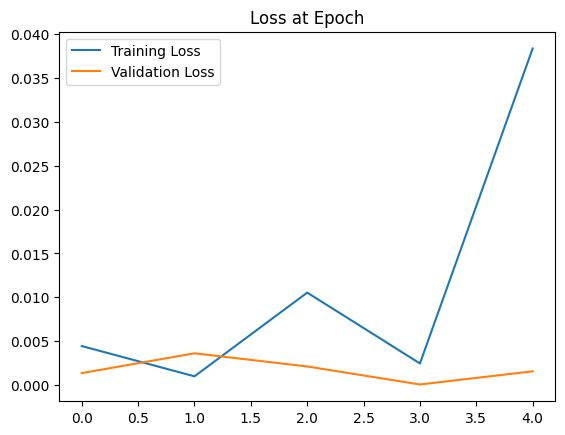

In [ ]:
# Graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

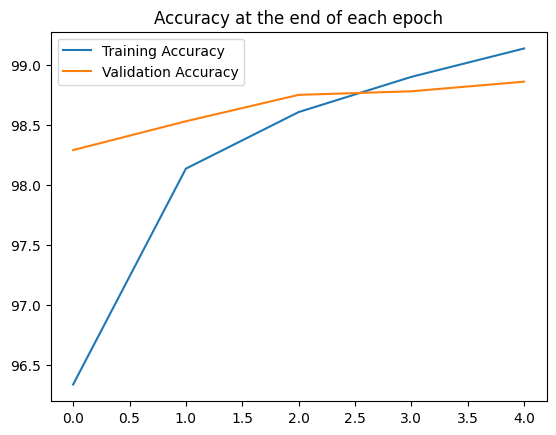

In [ ]:
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [ ]:
test_load_everything = DataLoader(test_data, batch_size =10000, shuffle = False)

In [ ]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [ ]:
correct.item()/len(test_data)*100

98.86

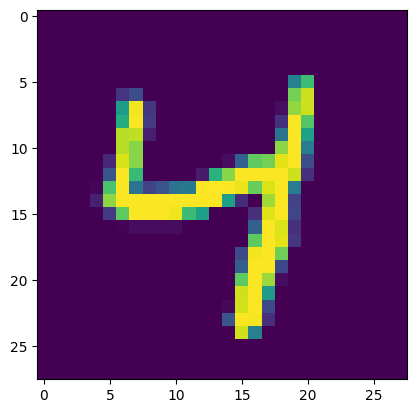

In [ ]:
# grab an image
plt.imshow(test_data[1978][0].reshape(28,28))

In [ ]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[1978][0].view(1,1,28,28))


In [ ]:
torch.max(new_prediction,1)[1].item()

4

In [137]:
class SkipConn(nn.Module):
	""" 
	Linear torch model with skip connections between every hidden layer\
	as well as the original input appended to every layer.\
	Because of this, each hidden layer contains `2*hidden_size+2` params\
	due to skip connections.
	Uses relu activations and one final sigmoid activation.

	Parameters: 
	hidden_size (float): number of non-skip parameters per hidden layer
	num_hidden_layers (float): number of hidden layers
	"""
	def __init__(self, hidden_size=100, num_hidden_layers=7, init_size=2, linmap=None):
		super(SkipConn,self).__init__()
		out_size = hidden_size

		self.inLayer = nn.Linear(init_size, out_size)
		self.relu = nn.LeakyReLU()
		hidden = []
		for i in range(num_hidden_layers):
			in_size = out_size*2 + init_size if i>0 else out_size + init_size
			hidden.append(nn.Linear(in_size, out_size))
		self.hidden = nn.ModuleList(hidden)
		self.outLayer = nn.Linear(out_size*2+init_size, 1)
		self.tanh = nn.Tanh()
		self.sig = nn.Sigmoid()
		self._linmap = linmap

	def forward(self, x):
		if self._linmap:
			x = self._linmap.map(x)
		cur = self.relu(self.inLayer(x))
		prev = torch.tensor([]).cpu()
		for layer in self.hidden:
			combined = torch.cat([cur, prev, x], 1)
			prev = cur
			cur = self.relu(layer(combined))
		y = self.outLayer(torch.cat([cur, prev, x], 1))
		return (self.tanh(y)+1)/2 # hey I think this works slightly better
		# return self.sig(y)


class Fourier2D(nn.Module):
    def __init__(self, fourier_order=4, hidden_size=100, num_hidden_layers=7, linmap=None):
        super(Fourier2D,self).__init__()
        self.fourier_order = fourier_order
        self.inner_model = SkipConn(hidden_size, num_hidden_layers, (fourier_order*fourier_order*4) + 2)
        self._linmap = linmap
        self.orders = torch.arange(0, fourier_order).float().to('cuda')

    def forward(self,x):
        if self._linmap:
            x = self._linmap.map(x)
        features = [x]
        for n in self.orders:
            for m in self.orders:
                features.append((torch.cos(n*x[:,0])*torch.cos(m*x[:,1])).unsqueeze(-1))
                features.append((torch.cos(n*x[:,0])*torch.sin(m*x[:,1])).unsqueeze(-1))
                features.append((torch.sin(n*x[:,0])*torch.cos(m*x[:,1])).unsqueeze(-1))
                features.append((torch.sin(n*x[:,0])*torch.sin(m*x[:,1])).unsqueeze(-1))
        fourier_features = torch.cat(features, 1)
        return self.inner_model(fourier_features)
    
class NewSimpleModel(nn.Module):
    # Input layer (4 features of the flower) --> Hidden layer ---> ourput of (3 categories)
    def __init__(self, in_features=4, h1=8,h2=9, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h2)
        self.fc4 = nn.Linear(h2,h2)
        self.out = nn.Linear(h2,out_features)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        return x

In [138]:
model = NewSimpleModel(784,300,100,10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [139]:


# import time
# start_time = time.time()

# # Tracker vars
# epochs = 5
# train_losses = []
# test_losses = []

# train_correct = []
# test_correct = []
# # For loops for Epochs
# for i in range(epochs):
#     trn_corr = 0
#     tst_corr = 0
    
#     # Training
#     for b, (X_train, y_train) in enumerate(train_loader):
#         b+=1
#         y_pred = model(X_train)
#         loss = criterion(y_pred, y_train)
        
#         predicted = torch.max(y_pred.data, 1)[1]
#         batch_corr = (predicted == y_train).sum()
#         trn_corr += batch_corr
        
#         # Update Params
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if b%600 == 0:
#             print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
        
#     train_losses.append(loss)
#     train_correct.append(trn_corr)
    
    
#     # Testing
#     with torch.no_grad():
#         for b, (X_test, y_test) in enumerate(test_loader):
#             y_val = model(X_test)
#             predicted = torch.max(y_val.data, 1)[1]
#             tst_corr += (predicted ==  y_test).sum()
            
#     loss = criterion(y_val, y_test)
#     test_losses.append(loss)
#     test_correct.append(tst_corr)





# current_time = time.time()
# total = current_time - start_time
# print(f'Training took {time/60} minutes!')

In [145]:
X = []
y = []
for i, (X_train, y_train) in enumerate(train_data):
   # y_pred = model(torch.reshape(X_train[i],(784,)))
   X.append(X_train[0])
   y.append(y_train)
   # loss = criterion(y_pred, torch.tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]))
   
   
   # optimizer.zero_grad()
   # loss.backward()
   # optimizer.step()
X.append(X_train)
# for i, (X_train, y_train) in enumerate(train_data):
#    # X_train.shape
#    break
# # torch.reshape(X_train,(-1,)).shape

ModuleNotFoundError: No module named 'tensorflow_datasets'